# Table of Contents
 <p><div class="lev1 toc-item"><a href="#腾讯数据整理" data-toc-modified-id="腾讯数据整理-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>腾讯数据整理</a></div><div class="lev2 toc-item"><a href="#导入数据" data-toc-modified-id="导入数据-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>导入数据</a></div><div class="lev2 toc-item"><a href="#得到数据坐标的最大最小值" data-toc-modified-id="得到数据坐标的最大最小值-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>得到数据坐标的最大最小值</a></div><div class="lev2 toc-item"><a href="#导入黄山风景区地理位置信息" data-toc-modified-id="导入黄山风景区地理位置信息-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>导入黄山风景区地理位置信息</a></div><div class="lev2 toc-item"><a href="#数据校准" data-toc-modified-id="数据校准-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>数据校准</a></div><div class="lev1 toc-item"><a href="#校准黄山wifi数据" data-toc-modified-id="校准黄山wifi数据-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>校准黄山wifi数据</a></div><div class="lev2 toc-item"><a href="#载入黄山数据" data-toc-modified-id="载入黄山数据-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>载入黄山数据</a></div><div class="lev2 toc-item"><a href="#ap布设点经纬度对应" data-toc-modified-id="ap布设点经纬度对应-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>ap布设点经纬度对应</a></div>

# 腾讯数据整理

## 导入数据

In [95]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import sparse
%matplotlib inline
plt.style.use('ggplot')
import datetime
import os

pd.set_option('display.width', 200)
dir_path = os.path.dirname(os.getcwd())
#读入腾讯位置数据
os.chdir(dir_path+'/TencentData')
files = os.listdir()[1:]
tencent_data = []
for file in files:
    data_temp = pd.read_csv(file, usecols=['time','data'])
    tencent_data.append(data_temp)
tencent_data = pd.concat(tencent_data).reset_index(drop=True).drop_duplicates()
#tencent_data['time'] = pd.to_datetime(tencent_data.time)

## 得到数据坐标的最大最小值

In [100]:
#得到坐标数据最大最小值
def str_info(data):
    data = pd.Series(data.split('|')[:-1])
    data_len = data.apply(lambda x:len(x.split(',')))
    loc_x = data[data_len >= 2].apply(lambda x:int(x.split(',')[1]))
    loc_y = data[data_len >= 2].apply(lambda x:int(x.split(',')[0]))
    x_max = loc_x.max()
    x_min = loc_x.min()
    y_max = loc_y.max()
    y_min = loc_y.min()
    return x_max, x_min, y_max, y_min

def get_data_info(frame):
    data_temp = frame.data.iloc[0]
    x_max, x_min, y_max, y_min = str_info(data_temp)
    frame['x_max'] = x_max
    frame['x_min'] = x_min
    frame['y_max'] = y_max
    frame['y_min'] = y_min
    return frame

tencent_data = tencent_data.groupby('time').apply(get_data_info).reset_index(drop=True)

In [110]:
x_max = tencent_data.x_max.max()
x_min = tencent_data.x_min.min()
y_max = tencent_data.y_max.max()
y_min = tencent_data.y_min.min()

## 导入黄山风景区地理位置信息

In [63]:
f = open(dir_path+'/info/HuangShan_geoinfo.txt')
geo_information = f.read()
geo_information = pd.Series(geo_information.replace('\"','').split('\n'))
dict_key = geo_information.apply(lambda x:x.split(':')[0])
dict_value = geo_information.apply(lambda x:x.split(':')[1])
geo_information = dict(zip(dict_key, dict_value))
gcj = ['center_gcj','lower_left','upper_right']
for i in gcj:
    geo_information[i] = (float(geo_information[i].split(',')[0]), float(geo_information[i].split(',')[1]))

In [75]:
center = geo_information['center_gcj']
l_left = geo_information['lower_left']
u_right = geo_information['upper_right']
bound = geo_information['boundary']
bound = pd.DataFrame(bound.split('|')[:-1])
bound.columns = ['location']
bound['lat'] = bound.location.apply(lambda x:float(x.split(',')[0]))
bound['lon'] = bound.location.apply(lambda x:float(x.split(',')[1]))

## 数据校准

In [111]:
(u_right[0] - l_left[0])/(y_max - y_min)

0.00010095636025998101

In [112]:
(u_right[1] - l_left[1])/(x_max - x_min)

0.00010179789473683717

In [114]:
(u_right[0] - center[0])/y_max

0.00010313213822717324

In [116]:
(center[0] - l_left[0])/-y_min

9.8780582292788788e-05

In [115]:
(u_right[1] - center[1])/x_max

9.6583280665937858e-05

In [117]:
(center[1] - l_left[1])/-x_min

0.00010708769832360185

In [164]:
#坐标数值转换成经纬度
def x2lon(x):
    return x*0.0001 + center[1]
def y2lat(y):
    return y*0.0001 + center[0]

def str_loc(frame):
    data_temp = frame.loc_str.iloc[0].split(',')
    frame['x'] = int(data_temp[1])
    frame['y'] = int(data_temp[0])
    if len(data_temp) == 3:
        frame['human_cnt'] = int(data_temp[2])
    else:
        frame['human_cnt'] = 1
    frame['loc_str'] = data_temp[1]+','+data_temp[0]
    return frame
    
def str2dataframe(data):
    data = pd.DataFrame(data.split('|')[:-1])
    data.columns = ['loc_str']
    data = data.groupby('loc_str').apply(str_loc).reset_index(drop=True)
    data['lon'] = data.x.apply(x2lon)
    data['lat'] = data.y.apply(y2lat)
    return data

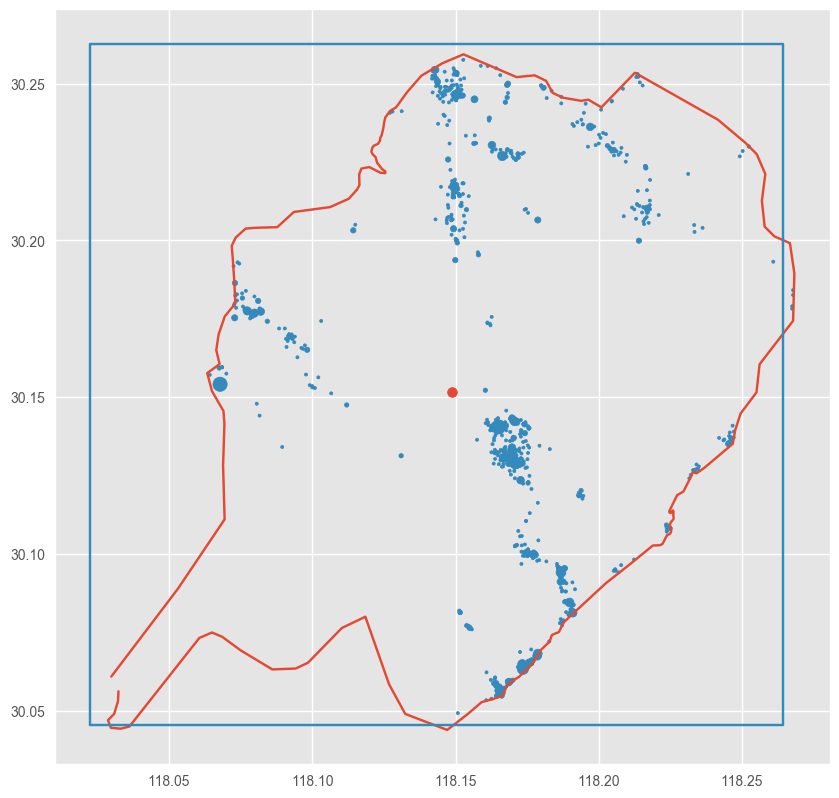

In [126]:
data = tencent_data[tencent_data.time == '2017-01-20 20:00:00'].data.iloc[0]
data = str2dataframe(data)

fig = plt.figure(figsize=(10,10),dpi=100)
ax = fig.add_subplot(111)
ax.plot(bound.lon,bound.lat)
ax.scatter(center[1],center[0])
ax.plot([l_left[1],u_right[1],u_right[1],l_left[1],l_left[1]],[l_left[0],l_left[0],u_right[0],u_right[0],l_left[0]])
ax.scatter(data.lon, data.lat, s=data.human_cnt*5)

# 校准黄山wifi数据

## 载入黄山数据

In [127]:
os.chdir(dir_path+'/info')
#载入ap点位
ap = pd.read_csv('AP.csv', encoding='gbk')
ap.location = ap.location.astype(str)
#不同区域的代码
area = pd.read_csv('area.csv', encoding='gbk')
area.area = area.area.astype(str)
ap = pd.merge(ap, area).sort_values('ap_seq')
ap_reduce = ap.loc[:,['ap_seq','area_id']]

#import经过整理的vendor
vendor = pd.read_csv('oui.csv', encoding='gbk')
vendor.columns = ['mac6', 'vendor']
vendor['vendor'] = vendor.vendor.str.replace('"', '')
vendor['mac6'] = vendor.mac6.str.upper()
v_names = ['Apple', 'Xiaomi', 'Samsung', 'Huawei', 'Motorola', 'Microsoft', 'Oppo', 'H3C', 'Aruba', 'TP-LINK', 'D-Link', 'zte',
           'Murata', 'MEIZU', 'Intel', 'vivo', 'Hon Hai', 'HTC', 'Lenovo Mobile', 'Cisco', 'Ereneben', 'AzureWave', 'ASUSTek',
           'Sony Mobile', 'Liteon', 'LG Electronics', 'Nokia', 'Amazon', 'OnePlus', 'SYNTECH (HK)', 'Gionee', 'Smartisan', 'BBK',
           'Yulong', 'Qiku', 'Hisense', 'Tenda', 'Jing Ren', 'Wistron', 'Doukan', 'InPro', 'Dell', 'Net Com', 'Bilian', 'EASY3CALL',
           'Lemobile', 'Airgo', 'Wingtech', 'Paragon', 'Ruckus Wireless', 'RF-LINK', 'Le Shi Zhi Xin', 'Hui Zhou Gaoshengda', 
           'HIWIFI', 'Chicony', 'Beijing SHENQI', 'SYNTECH', 'AMPAK', 'private', 'LONGCHEER', 'TCT']
for name in v_names:
    vendor['vendor'] = np.where(vendor.vendor.str.contains(name, case=False), name, vendor.vendor)
'''
device_name = ['H3C', 'Aruba', 'TP-LINK', 'D-Link', 'Intel', 'Hon Hai', 'Cisco', 'AzureWave', 'Liteon', 
               'SYNTECH (HK)', 'Tenda', 'Jing Ren', 'Wistron', 'Doukan', 'InPro', 'Net Com', 'Bilian', 'EASY3CALL',
                'Lemobile', 'Airgo', 'Wingtech', 'Paragon', 'Ruckus Wireless', 'RF-LINK', 'Le Shi Zhi Xin', 'Hui Zhou Gaoshengda',
                'HIWIFI', 'Chicony', 'Beijing SHENQI', 'SYNTECH', 'AMPAK', 'private']
'''
mobile_name = ['Apple', 'Murata', 'Xiaomi', 'Huawei', 'Samsung', 'Oppo', 'vivo', 'MEIZU', 'Yulong', 'zte', 
               'Sony Mobile', 'BBK', 'Lenovo Mobile', 'HTC', 'Smartisan', 'LG Electronics', 'Qiku', 'Microsoft', 'Gionee', 
               'TCT', 'OnePlus', 'LONGCHEER', 'Hisense', 'Motorola', 'Nokia']
vendor['mobile']=np.where(vendor.vendor.isin(mobile_name), True, False)

/Users/zhangyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


In [131]:
#载入数据
tw_span = 5
files = os.listdir(dir_path+'/CleanData')
data = []
fileMax = 100
fileCnt = 0
for datafile in files:
    path = dir_path + '/CleanData/' + datafile
    frame = pd.read_csv(path, encoding='gbk')                 
    data.append(frame)
    fileCnt += 1
    if fileCnt >= fileMax:
        break
data = pd.concat(data, ignore_index = False)
data['date'] = pd.to_datetime(data.date)
data['tw_all'] = ((data.date-data.date.min())/pd.Timedelta(days=1)*(24*60/tw_span)+data.tw).astype(int)
del data['Unnamed: 0']
data['mac6'] = data.mac.str[:6]
data = pd.merge(data, vendor, on='mac6')
data = pd.merge(data, ap_reduce, on='ap_seq')
s = ['2','6','A','E']
data['randMac'] = data.mac.str[1].isin(s)
data = data[-data.randMac]
m_data = data[data.mobile==True]

In [132]:
#去掉只在新国线或索道下站出现的mac (mac数量从184016下降到151251)
temp = m_data[m_data.ap_seq.isin([1,2,3,14,15,18])==False]
mac = temp.groupby(['mac','date']).apply(len).reset_index(name='cnt').groupby('mac').apply(len).reset_index(name='day_cnt')
location = temp.groupby(['mac','ap_seq']).apply(len).reset_index(name='cnt').groupby('mac').apply(len).reset_index(name='location_cnt')
mac = pd.merge(mac, location, on='mac')
g_data = m_data[m_data.mac.isin(mac.mac)]
g_data['weekday'] = g_data.date.dt.weekday < 5
g_data = g_data.sort_values(['mac','tw_all'])

/Users/zhangyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [133]:
#去掉工作人员
data_temp = g_data.groupby(['mac','date']).apply(len).reset_index()
data_temp = data_temp.groupby('mac').apply(len).reset_index(name='cnt')
staff = data_temp[data_temp.cnt > 7]
staff_mac = staff.mac
g_data = g_data[g_data.mac.isin(staff_mac) == False]

In [134]:
#标记春节
def festival(frame):
    if (frame.date.iloc[0] > pd.to_datetime('2017-01-26 00:00:00')) and (frame.date.iloc[0] < pd.to_datetime('2017-02-03 00:00:00')):
        frame['festival'] = True
    else:
        frame['festival'] = False
    return frame
g_data = g_data.groupby('date').apply(festival)
g_data = g_data[['date','mac','tw','tw_all','vendor','area_id','weekday','festival']]

## ap布设点经纬度对应

(30.05, 30.2)

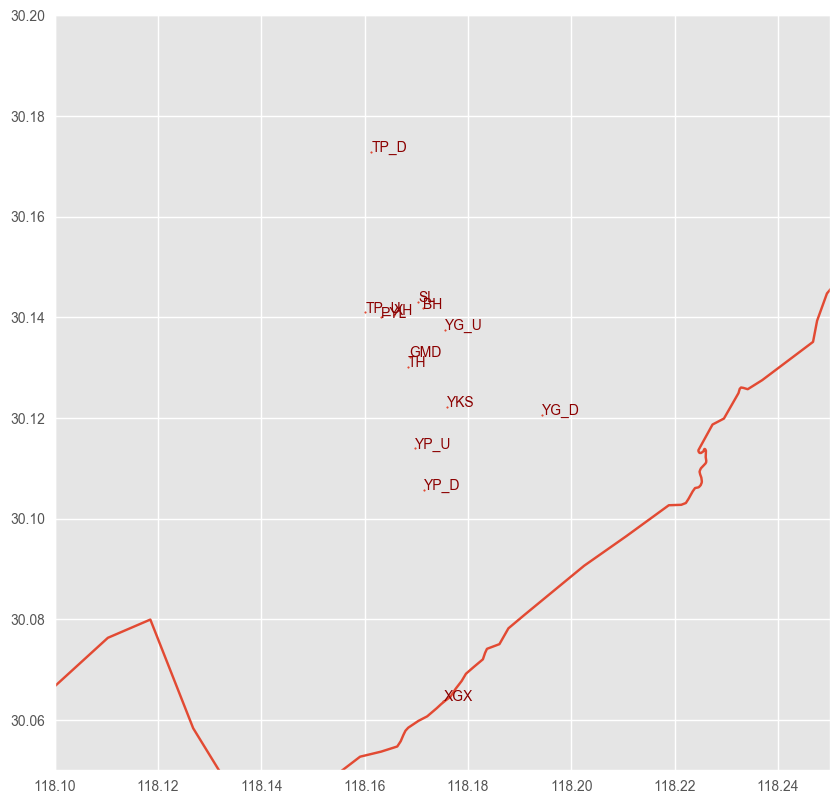

In [148]:
area_location = pd.read_csv('area_location.csv')
fig = plt.figure(figsize=(10,10),dpi=100)
ax = fig.add_subplot(111)
ax.plot(bound.lon,bound.lat)
ax.scatter(area_location.lon_t, area_location.lat_t, s=1)
for i in range(14):
    ax.text(area_location.lon_t.iloc[i], area_location.lat_t.iloc[i], area_location.area.iloc[i], color='darkred')
ax.set_xlim(118.10, 118.25)
ax.set_ylim(30.05, 30.20)

In [150]:
area_location['x'] = (area_location.lon_t - center[1])/0.0001
area_location['y'] = (area_location.lat_t - center[0])/0.0001

area_location['x'] = area_location.x.astype('int')
area_location['y'] = area_location.y.astype('int')
area_location['x'] = area_location.x.astype('str')
area_location['y'] = area_location.y.astype('str')

area_location['loc_str'] = area_location.x + ',' + area_location.y

In [161]:
def str2dataframe2(data):
    data = pd.DataFrame(data.split('|')[:-1])
    data.columns = ['loc_str']
    data = data.groupby('loc_str').apply(str_loc).reset_index(drop=True)
    return data

In [195]:
data = tencent_data.data.iloc[180]
data = str2dataframe2(data)

pd.merge(area_location, data[['loc_str','human_cnt']], on='loc_str', how='left')

,area,x,y,area_id,lon_b,lat_b,lon_t,lat_t,loc_str,human_cnt
0,BH,226,-99,0,118.177771,30.148025,118.171279,30.141769,"226,-99",NaN
1,GMD,200,-195,1,118.175238,30.138285,118.168704,30.132156,"200,-195",2.0
2,GMD,200,-195,1,118.175238,30.138285,118.168704,30.132156,"200,-195",1.0
3,GMD,200,-195,1,118.175238,30.138285,118.168704,30.132156,"200,-195",3.0
4,GMD,200,-195,1,118.175238,30.138285,118.168704,30.132156,"200,-195",1.0
5,PYL,145,-116,2,118.169722,30.145902,118.163152,30.139987,"145,-116",NaN
6,SL,218,-86,3,118.176980,30.149025,118.170421,30.143030,"218,-86",1.0
7,TH,196,-215,4,118.174789,30.136189,118.168307,30.130152,"196,-215",NaN
8,TP_D,126,212,5,118.167872,30.178439,118.161296,30.172901,"126,212",NaN
9,TP_U,115,-106,6,118.166668,30.146839,118.160132,30.140998,"115,-106",NaN
